# CNNで音声データを学習できるかどうかテスト
- Ref:https://qiita.com/cvusk/items/61cdbce80785eaf28349#cnn%E3%81%AE%E5%AE%9A%E7%BE%A9
    - 

In [1]:
import os
import time as ti
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import model_selection
from sklearn import preprocessing

import librosa
import librosa.display

import IPython.display as ipd

In [2]:
base_dir = "./../"
dataset_dir = os.path.join(base_dir, "dataset/")
esc_dir = os.path.join(base_dir, "ESC-50/")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

In [3]:
meta_data = pd.read_csv(meta_file)
meta_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [4]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path)
    return x, fs

def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

wave size:(110250,)
melsp size:(128, 862)
sampling rate:22050


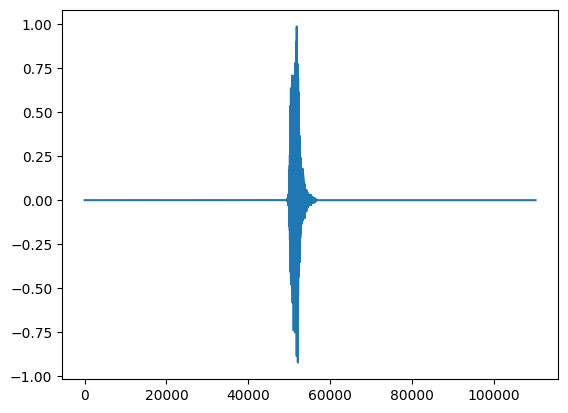

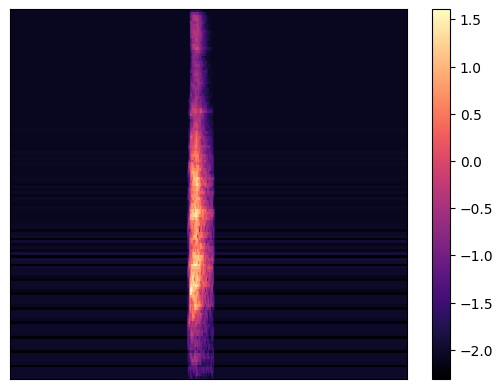

In [5]:
x, fs = load_wave_data(audio_dir, meta_data.loc[0, "filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [6]:
melsp.shape

(128, 862)

In [7]:
ipd.Audio(x, rate=fs)

In [8]:
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

wave size:(110250,)
melsp size:(128, 862)
samping rate:22050


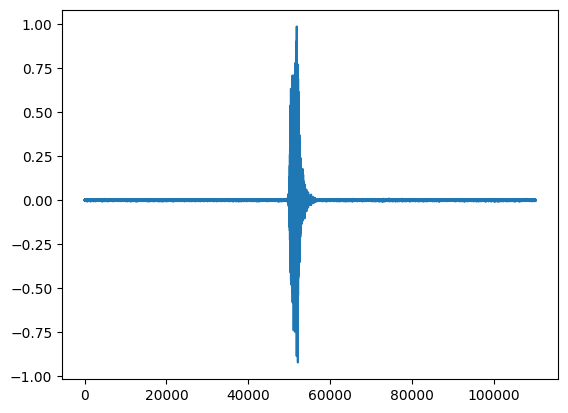

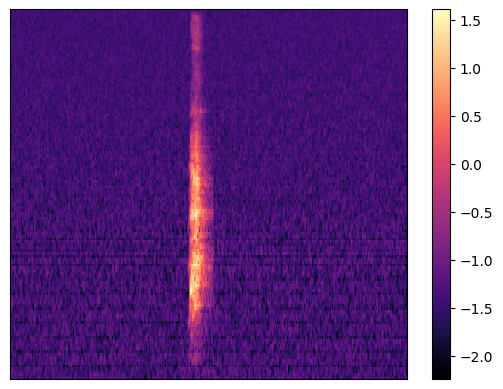

In [9]:
x_w = add_white_noise(x)
melsp = calculate_melsp(x_w)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_w.shape, melsp.shape, fs))
show_wave(x_w)
show_melsp(melsp, fs)

In [10]:
ipd.Audio(x_w, rate=fs)

In [11]:
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

wave size:(110250,)
melsp size:(128, 862)
samping rate:22050


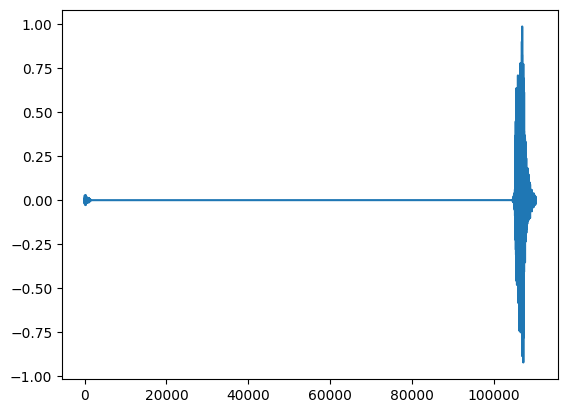

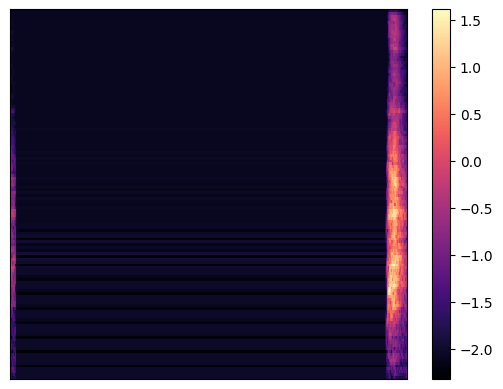

In [12]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)

In [13]:
ipd.Audio(x_ss, rate=fs)

In [14]:
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(y=x, rate=rate)
    if len(x) > input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

wave size:(110250,)
melsp size:(128, 862)
samping rate:22050


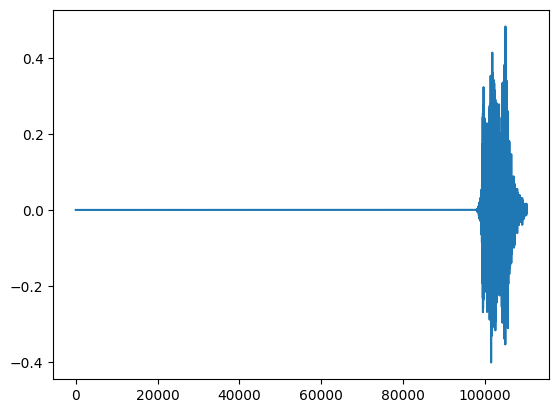

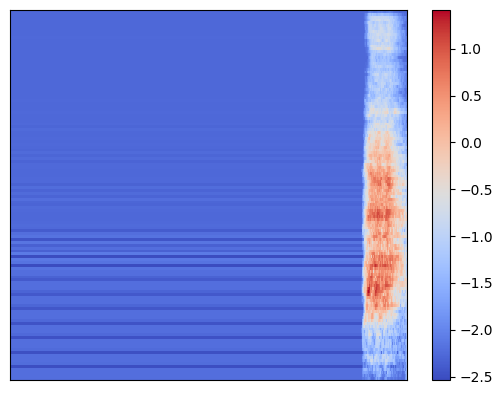

In [15]:
x_st = stretch_sound(x, rate=0.5)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)

In [16]:
ipd.Audio(x_st, rate=fs)

In [86]:
x = list(meta_data.loc[:, "filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


In [18]:
a = np.zeros(50, dtype=np.int16)
for c in y_test:
    a[c] += 1
print(a)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]


In [19]:
freq = 128
time = 862

In [20]:
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [21]:
path = os.path.join(dataset_dir, "esc_melsp_test.npz")
if not os.path.exists(path):
    save_np_data(path, x_test, y_test)

In [22]:
path = os.path.join(dataset_dir, "esc_melsp_train_raw.npz")
if not os.path.exists(path):
    save_np_data(path, x_train,  y_train)

In [23]:
path = os.path.join(dataset_dir, "esc_melsp_train_wn.npz")
if not os.path.exists(path):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data(path, x_train,  y_train, aug=add_white_noise, rates=rates)

In [24]:
path = os.path.join(dataset_dir, "esc_melsp_train_ss.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data(path, x_train,  y_train, aug=shift_sound, rates=rates)

In [25]:
path = os.path.join(dataset_dir, "esc_melsp_train_st.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data(path, x_train,  y_train, aug=stretch_sound, rates=rates)

In [26]:
path = os.path.join(dataset_dir, "esc_melsp_train_com.npz")
if not os.path.exists(path):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez(path, x=np_data, y=np_targets)

In [27]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [98]:
_train_files = ["esc_melsp_train_raw.npz", 
               "esc_melsp_train_ss.npz",
               "esc_melsp_train_st.npz", 
               "esc_melsp_train_wn.npz",
               "esc_melsp_train_com.npz"]
_test_file = "esc_melsp_test.npz"

In [99]:
train_files = [os.path.join(dataset_dir, path) for path in _train_files]
test_file = os.path.join(dataset_dir, _test_file)

In [100]:
train_num = 1500
test_num = 500

In [101]:
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

In [102]:
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

In [103]:
type(x_train)

numpy.ndarray

In [104]:
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [105]:
classes = 50
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

In [106]:
x_train = x_train.reshape(train_num*5, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

In [36]:
"""
classes = 50
#y_test = keras.utils.to_categorical(y_test, classes)
x_test = x_test.reshape(test_num, freq, time, 1)
"""

'\nclasses = 50\n#y_test = keras.utils.to_categorical(y_test, classes)\nx_test = x_test.reshape(test_num, freq, time, 1)\n'

In [37]:
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                y_train.shape, 
                                                                x_test.shape, 
                                                                y_test.shape))

x train:(7500, 128, 862, 1)
y train:(7500, 50)
x test:(500, 128, 862, 1)
y test:(500, 50)


In [38]:
y_test.shape

(500, 50)

In [39]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [40]:
inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 862, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 431, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 431, 32  544         ['input_1[0][0]']                
                                )                                                             

In [41]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, amsgrad=True)

In [42]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [43]:
model_dir = "./../models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [44]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{accuracy:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [45]:
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

In [46]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1965432598670142103
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3643801600
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7223943263654907804
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [47]:
batch_size = 16
epochs = 10

start_time = ti.time()
with tensorflow.device('/GPU:0'):
    
    training_generator = MixupGenerator(x_train, y_train)()
    model.fit_generator(generator=training_generator,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, 
                        verbose=1,
                        shuffle=True,
                        callbacks=[es_cb, cp_cb])

    """
    model.fit(x_train, y_train,
              steps_per_epoch=x_train.shape[0] // batch_size,
              validation_data=(x_test, y_test),
              epochs=epochs, 
              verbose=1,
              shuffle=True,
              callbacks=[es_cb, cp_cb])
    """
    
end_time = ti.time()
print("time:", end_time - start_time)

Epoch 1/10


C:\Users\shuhei\AppData\Local\Temp\ipykernel_1612\2498144003.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


468/468 [==============================] - ETA: 0s - loss: 3.2698 - accuracy: 0.1648
Epoch 1: val_loss improved from inf to 3.19245, saving model to ./../models\esc50_.01_3.1925_0.1648.hdf5
468/468 [==============================] - 311s 635ms/step - loss: 3.2698 - accuracy: 0.1648 - val_loss: 3.1925 - val_accuracy: 0.1680
Epoch 2/10
468/468 [==============================] - ETA: 0s - loss: 2.5196 - accuracy: 0.3540
Epoch 2: val_loss improved from 3.19245 to 2.19891, saving model to ./../models\esc50_.02_2.1989_0.3540.hdf5
468/468 [==============================] - 296s 632ms/step - loss: 2.5196 - accuracy: 0.3540 - val_loss: 2.1989 - val_accuracy: 0.3880
Epoch 3/10
468/468 [==============================] - ETA: 0s - loss: 2.1490 - accuracy: 0.4738
Epoch 3: val_loss improved from 2.19891 to 1.70141, saving model to ./../models\esc50_.03_1.7014_0.4738.hdf5
468/468 [==============================] - 297s 634ms/step - loss: 2.1490 - accuracy: 0.4738 - val_loss: 1.7014 - val_accuracy: 0.

AttributeError: 'int' object has no attribute 'time'

- ResourceExhaustedError: Graph execution error:

- batch size 2
Node: 'model/conv2d_13/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv2d_13/Conv2D}}]] [Op:__inference_train_function

- batch size 4
Node: 'model/conv2d_12/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv2d_12/Conv2D}}]] [Op:__inference_train_function

- batch size 8
Node: 'model/conv2d_4/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv2d_4/Conv2D}}]] [Op:__inference_train_function

- batch size 16
Node: 'model/conv2d/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 24281104 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv2d/Conv2D}}]] [Op:__inference_train_function

- batch size 32
Node: 'model/conv2d_8/Conv2D'
OOM when allocating tensor with shape[33,128,431,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_8/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5269]_5269]_5269]_5190]_5190]

In [49]:
model = load_model("./../models/esc50_.10_0.8710_0.8304.hdf5")

In [50]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

16/16 [==============================] - 6s 363ms/step - loss: 0.8710 - accuracy: 0.7500
[0.8710129857063293, 0.75]


wave size:(110250,)
melsp size:(128, 862)
sampling rate:22050


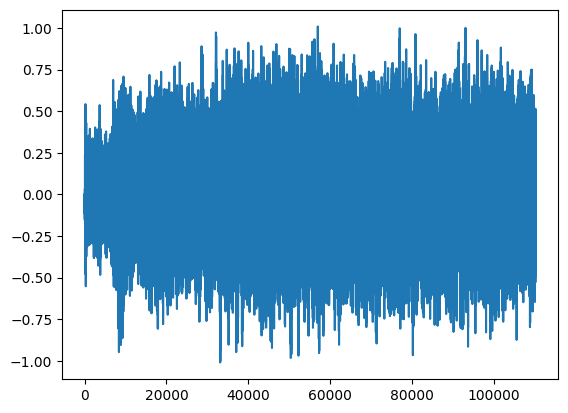

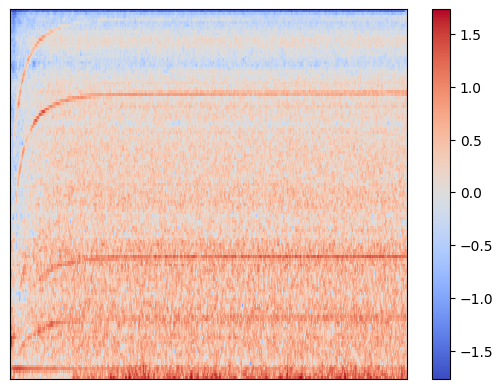

In [81]:
x, fs = load_wave_data(audio_dir, meta_data.loc[2, "filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [82]:
ipd.Audio(x, rate=fs)

In [83]:
pred = model.predict(melsp.reshape(1, 128, 862, 1))

1/1 [==============================] - 0s 17ms/step


In [84]:
pred_label = np.argmax(pred)

In [85]:
pred_label

36